In [20]:
from google.colab import drive
from IPython.display import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import keras
from glob import glob
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
from skimage import transform
import scipy
import datetime
import cv2
import tensorflow as tf
import time
from IPython import display


In [21]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [22]:
def load(Imgfile):              # Dataset is combination of both Input and Target Image, Hence This function 
  image = tf.io.read_file(Imgfile)   #..continue... separates the images
  image = tf.image.decode_jpeg(image)
  w = tf.shape(image)[1]
  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image


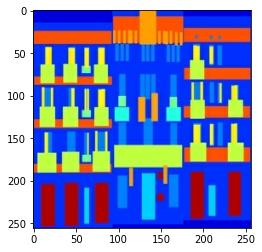

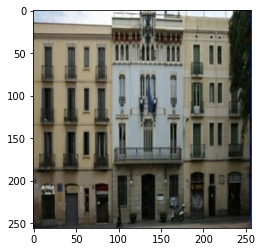

In [23]:
input, realImg = load('/content/drive/My Drive/dataset/facades/train/11.jpg')
plt.figure()
plt.imshow(input/255.0)
plt.figure()
plt.imshow(realImg/255.0)

In [24]:
def DataNormalize(InputImg,Target):  # Data Normalization, RandomCrop, Resizing Functions are used to 
    X1,X2 = [InputImg, Target]       # .... To prevent the network from overfitting of hig variance
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return X1,X2

def RandomCrop(InputImg,Target):
    s = [256,256,3]
    CropInput =  tf.image.random_crop(InputImg,size= s,seed = None)
    CropTarget = tf.image.random_crop(Target,size= s,seed = None)
    return CropInput,CropTarget

def ImageResize(InputImg,Target, height, width):
    ResizeInp = tf.image.resize(InputImg,[height,width], method = 'nearest')
    ResizeTar = tf.image.resize(Target,[height,width], method = 'nearest')
    return ResizeInp,ResizeTar



In [25]:
def RandomJitter_Normalize(InputImg, TargetImg):
    inputImg, targetImg = ImageResize(InputImg,TargetImg,286,286)
    inputImg, targetImg = RandomCrop(inputImg,targetImg)
    if tf.random.uniform(()) > 0.5:
      inputImg = tf.image.flip_left_right(inputImg)
      targetImg = tf.image.flip_left_right(targetImg)
    inputImg, targetImg = DataNormalize(inputImg, targetImg)    
    return inputImg, targetImg
# Load Train function perform random jitter to every Input image in the train dataset
def Load_Train(Imgfile):
    inputImg, targetImg = load(Imgfile)
    inputImg, targetImg = RandomJitter_Normalize(inputImg, targetImg)
    return inputImg, targetImg
# Load Test function perform datanormalization to every image sample in the test dataset
def Load_Test(Imgfile):
    inputImg, targetImg = load(Imgfile)
    inputImg, targetImg = ImageResize(inputImg, targetImg,256,256)
    inputImg, targetImg = DataNormalize(inputImg,targetImg)
    return inputImg, targetImg

In [26]:
def Traindataset(Imgfile,BufferSize = 1000,BatchSize = 1):
    TrainDataset = tf.data.Dataset.list_files(Imgfile)
    TrainDataset = TrainDataset.map(Load_Train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    TrainDataset = TrainDataset.shuffle(BufferSize)
    TrainDataset = TrainDataset.batch(BatchSize)
    return TrainDataset

def Testdataset(Imgfile,BufferSize = 100,BatchSize = 1):
    TestDataset = tf.data.Dataset.list_files(Imgfile)
    TestDataset = TestDataset.map(Load_Test)
    TestDataset = TestDataset.shuffle(BufferSize)
    TestDataset = TestDataset.batch(BatchSize)
    return TestDataset


In [27]:
def DiscriminatorModel(Imgshape = (256,256,3)):
    
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=None)    
    InputImg = tf.keras.layers.Input(shape = Imgshape, name = 'inputimage')    
    TargetImg = tf.keras.layers.Input(shape = Imgshape, name = 'outputimage')
    
    x = tf.keras.layers.Concatenate(axis=-1)([InputImg, TargetImg])
    
    # Input Image and the Target image are Concatenated and passed as input image to the descriminator
    
    # C64 - C128 - C256- C512, architecture of 70x70 descriminator model
    
    # C64
    model = tf.keras.layers.Conv2D(64, 4, strides = 2,padding = 'same', kernel_initializer = initializer,use_bias=False)(x)    
    model = tf.keras.layers.LeakyReLU (alpha = 0.2)(model)
       
    # According to the paper Image-to-Image Translation with Conditional Adversarial Networks
    # BatchNormalization is applied to all layers except first layer.
    # Leaky Relu activation function with slope 0.2 Applied to all the layers
    # Sigmoid Function utilized at the Output layer
    
    # C128
    model = tf.keras.layers.Conv2D(128, 4, strides = 2, padding = 'same', kernel_initializer = initializer,use_bias=False)(model)    
    model = tf.keras.layers.BatchNormalization()(model)    
    model = tf.keras.layers.LeakyReLU(alpha = 0.2)(model)
    
    # C256
    model = tf.keras.layers.Conv2D(256, 4, strides = 2, padding = 'same', kernel_initializer = initializer,use_bias=False)(model)    
    model = tf.keras.layers.BatchNormalization()(model)    
    model = tf.keras.layers.LeakyReLU(alpha = 0.2)(model)
    
    #Zero-Padding
    model = tf.keras.layers.ZeroPadding2D(padding=1)(model)

    # C512
    model = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer = initializer,use_bias=False)(model)    
    model = tf.keras.layers.BatchNormalization()(model)    
    model = tf.keras.layers.LeakyReLU(alpha = 0.2)(model)
    
    #Zero-Padding
    model = tf.keras.layers.ZeroPadding2D(padding=1)(model)

    #Output layer
    model = tf.keras.layers.Conv2D(1, 4, kernel_initializer = initializer)(model)
        
    Model = tf.keras.Model(inputs = [InputImg, TargetImg], outputs = model)
    #Model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5), loss = 'binary_crossentropy', loss_weights = [0.5])

    return Model
    

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputimage (InputLayer)         [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
outputimage (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 256, 256, 6)  0           inputimage[0][0]                 
                                                                 outputimage[0][0]                
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 128, 64) 6144        concatenate_16[0][0]  

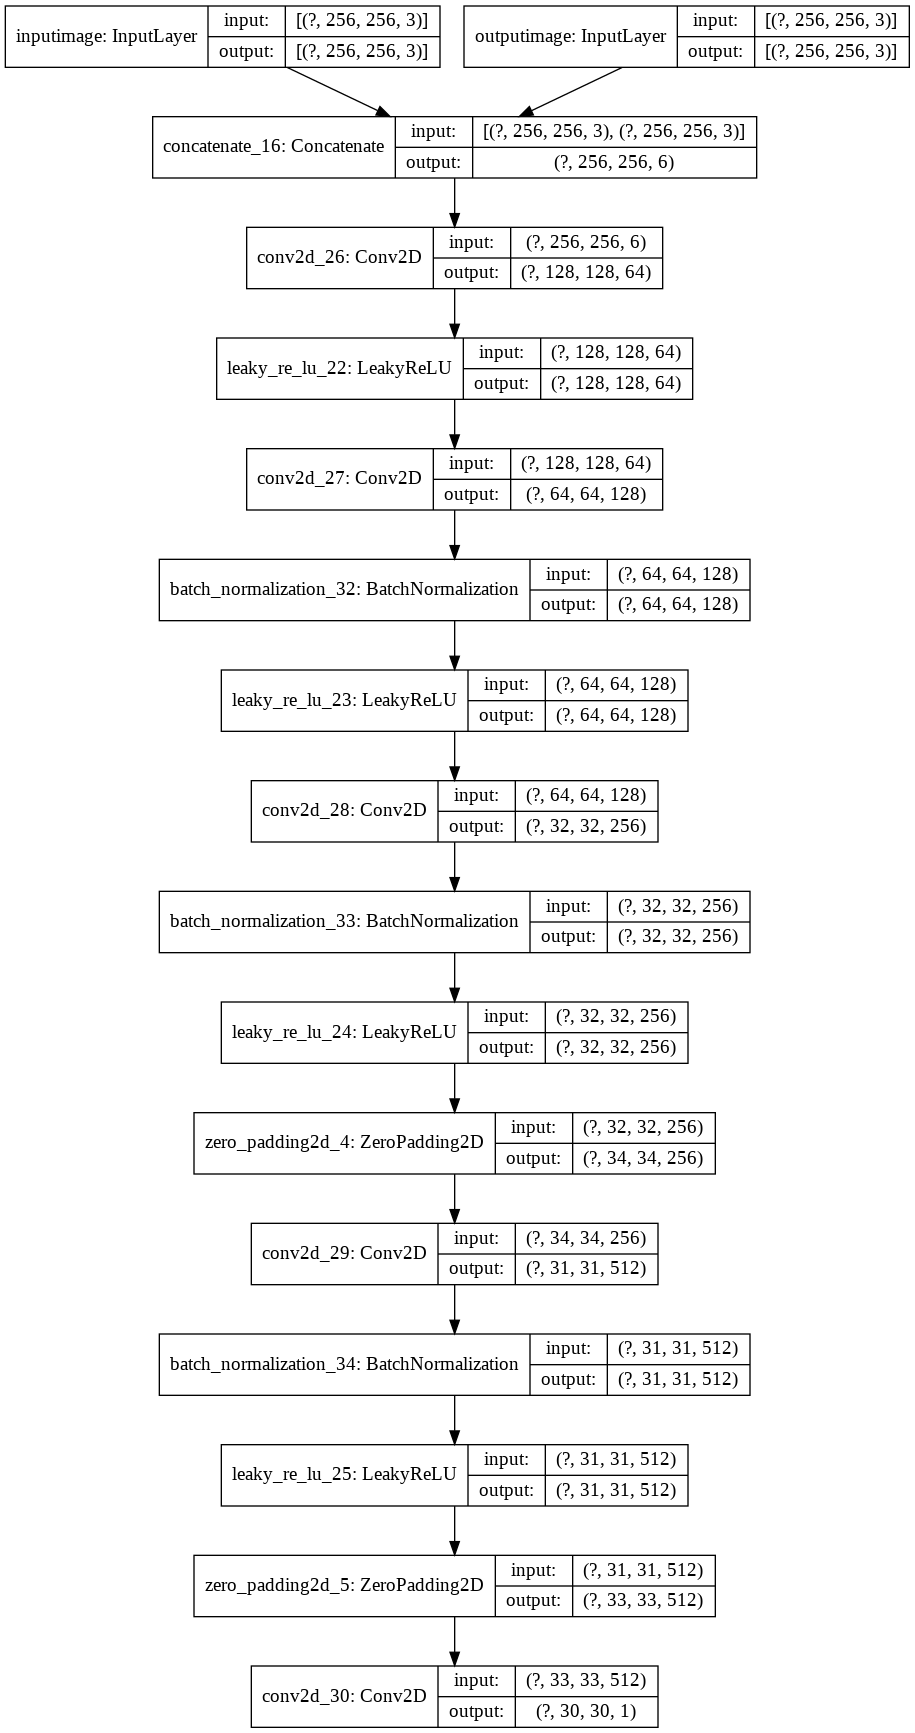

In [28]:
image_shape = [256,256,3]
model = DiscriminatorModel(image_shape)
model.summary()
tf.keras.utils.plot_model(model, to_file='Discriminator_model_plot.png', show_shapes=True, show_layer_names=True)


In [29]:
def Discriminator_Loss(Discriminator_Real,Discriminator_Fake):
    D1_Loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.keras.backend.ones_like(Discriminator_Real),Discriminator_Real) 
    D2_Loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.keras.backend.zeros_like(Discriminator_Fake),Discriminator_Fake)
    Total_Discriminator_Loss = D1_Loss + D2_Loss
    return Total_Discriminator_Loss

In [30]:
def GeneratorModel(ImgShape = (256,256,3)):
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=None)    
    InputImg = tf.keras.layers.Input(shape = ImgShape)    
   
    #According tot the Sources, U-net is combination of ecoder and decoder ans inter connected through skip connections

    # Encoder: C64 - C128 - C256 - C512 - C512 - C512 - C512 - C512
    # Decoder: CD512 - CD512 - CD512 - C512 - C256- C128 - C64
    # U-net Decoder with skip connection - CD512 - CD1024 - CD1024 - C1024 - C1024 - C512 - C256 - C128


    # Encoder
    
    # C64
    E1 = tf.keras.layers.Conv2D(64, 4, strides = 2,padding = 'same', kernel_initializer = initializer)(InputImg)    
    E1 = tf.keras.layers.LeakyReLU (alpha = 0.2)(E1)
       
    # C128
    E2 = tf.keras.layers.Conv2D(128, 4, strides = 2, padding = 'same', kernel_initializer = initializer)(E1)    
    E2 = tf.keras.layers.BatchNormalization()(E2)    
    E2 = tf.keras.layers.LeakyReLU(alpha = 0.2)(E2)
    
    # C256
    E3 = tf.keras.layers.Conv2D(256, 4, strides = 2, padding = 'same', kernel_initializer = initializer)(E2)    
    E3 = tf.keras.layers.BatchNormalization()(E3)    
    E3 = tf.keras.layers.LeakyReLU(alpha = 0.2)(E3)
    
    # C512
    E4 = tf.keras.layers.Conv2D(512, 4, strides = 2, padding = 'same', kernel_initializer = initializer)(E3)    
    E4 = tf.keras.layers.BatchNormalization()(E4)    
    E4 = tf.keras.layers.LeakyReLU(alpha = 0.2)(E4)
    
    # C512
    E5 = tf.keras.layers.Conv2D(512,4, strides = 2, padding = 'same', kernel_initializer = initializer)(E4)
    E5 = tf.keras.layers.BatchNormalization()(E5)    
    E5 = tf.keras.layers.LeakyReLU(alpha = 0.2)(E5)

    # C512
    E6 = tf.keras.layers.Conv2D(512, 4, strides = 2, padding = 'same', kernel_initializer = initializer)(E5)    
    E6 = tf.keras.layers.BatchNormalization()(E6)    
    E6 = tf.keras.layers.LeakyReLU(alpha = 0.2)(E6)
    
    # C512
    E7 = tf.keras.layers.Conv2D(512,4, strides = 2, padding = 'same', kernel_initializer = initializer)(E6)
    E7 = tf.keras.layers.BatchNormalization()(E7)    
    E7 = tf.keras.layers.LeakyReLU(alpha = 0.2)(E7)

   #BottelNeck

    x = tf.keras.layers.Conv2D(512,4, strides = 2, padding = 'same', kernel_initializer = initializer)(E7)
    x = tf.keras.layers.ReLU()(x)

    #Decoder
    
    # C512
    D1 = tf.keras.layers.Conv2DTranspose(512,4, strides = 2, padding = 'same', kernel_initializer = initializer)(x)
    D1 = tf.keras.layers.BatchNormalization()(D1) 
    D1 = tf.keras.layers.Dropout(rate = 0.5, noise_shape=None, seed=None)(D1, training = True)
    D1 = tf.keras.layers.ReLU()(D1)
    D1 = tf.keras.layers.Concatenate(axis=-1)([D1, E7])

    # C512
    D2 = tf.keras.layers.Conv2DTranspose(512,4, strides = 2, padding = 'same', kernel_initializer = initializer)(D1)
    D2 = tf.keras.layers.BatchNormalization()(D2) 
    D2 = tf.keras.layers.Dropout(rate = 0.5, noise_shape=None, seed=None)(D2, training = True)
    D2 = tf.keras.layers.ReLU()(D2)
    D2 = tf.keras.layers.Concatenate(axis=-1)([D2, E6])

    # C512
    D3 = tf.keras.layers.Conv2DTranspose(512,4, strides = 2, padding = 'same', kernel_initializer = initializer)(D2)
    D3 = tf.keras.layers.BatchNormalization()(D3) 
    D3 = tf.keras.layers.Dropout(rate = 0.5, noise_shape=None, seed=None)(D3, training = True)
    D3 = tf.keras.layers.ReLU()(D3)
    D3 = tf.keras.layers.Concatenate(axis=-1)([D3, E5])
    
    # C512
    D4 = tf.keras.layers.Conv2DTranspose(512,4, strides = 2, padding = 'same', kernel_initializer = initializer)(D3)
    D4 = tf.keras.layers.BatchNormalization()(D4) 
    D4 = tf.keras.layers.ReLU()(D4)
    D4 = tf.keras.layers.Concatenate(axis=-1)([D4, E4])
    
    # C256
    D5 = tf.keras.layers.Conv2DTranspose(256,4, strides = 2, padding = 'same', kernel_initializer = initializer)(D4)
    D5 = tf.keras.layers.BatchNormalization()(D5) 
    D5 = tf.keras.layers.ReLU()(D5)
    D5 = tf.keras.layers.Concatenate(axis=-1)([D5, E3])

    # C128
    D6 = tf.keras.layers.Conv2DTranspose(128,4, strides = 2, padding = 'same', kernel_initializer = initializer)(D5)
    D6 = tf.keras.layers.BatchNormalization()(D6) 
    D6 = tf.keras.layers.ReLU()(D6)
    D6 = tf.keras.layers.Concatenate(axis=-1)([D6, E2])

    # C64
    D7 = tf.keras.layers.Conv2DTranspose(64,4, strides = 2, padding = 'same', kernel_initializer = initializer)(D6)
    D7 = tf.keras.layers.BatchNormalization()(D7) 
    D7 = tf.keras.layers.ReLU()(D7)
    D7 = tf.keras.layers.Concatenate(axis=-1)([D7, E1])

    last = tf.keras.layers.Conv2DTranspose(3,4, strides = 2, padding = 'same', kernel_initializer = initializer)(D7)    
    OutputImg = tf.keras.activations.tanh (last)    
    Model = tf.keras.Model(inputs = InputImg, outputs = OutputImg)
    
    return Model
   


Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_26 (LeakyReLU)      (None, 128, 128, 64) 0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 64, 64, 128)  131200      leaky_re_lu_26[0][0]             
______________________________________________________________________________________

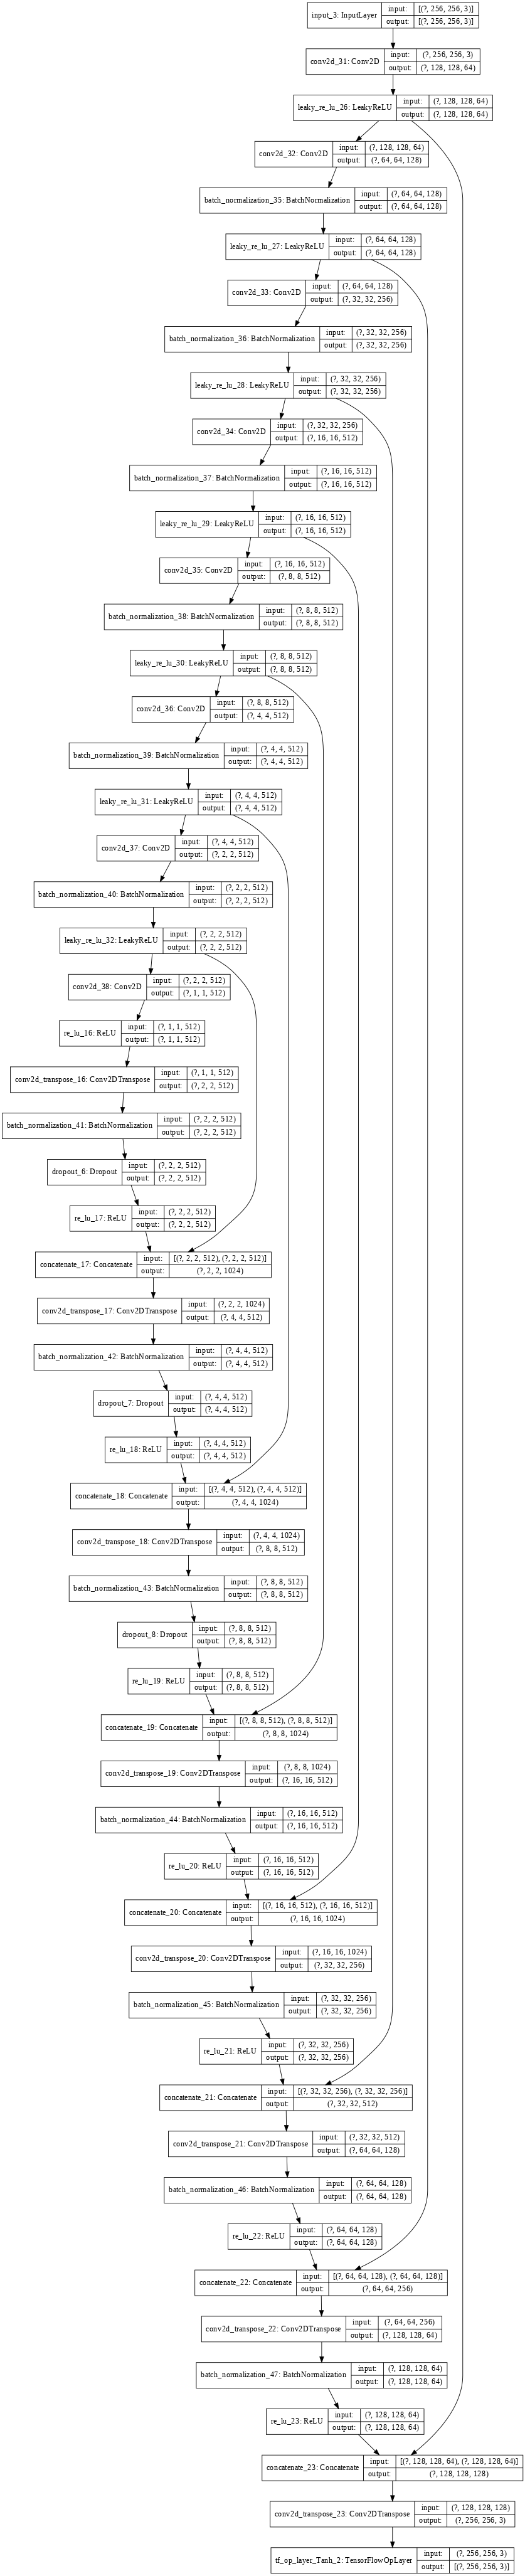

In [31]:
Imgshape = (256,256,3)
generator = GeneratorModel(Imgshape)
generator.summary()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [32]:
def Generator_Loss (DiscGop,GeneratorOutput, Target,Lambda = 100):
    GLoss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.keras.backend.ones_like(DiscGop),DiscGop) 
    L1_Loss = tf.math.reduce_mean(tf.abs(Target - GeneratorOutput), axis=None, keepdims=False, name=None) # Expectation (Difference between the target and generated value)
    Total_Generator_Loss = GLoss + (Lambda * L1_Loss)
    return Total_Generator_Loss,GLoss,L1_Loss



In [33]:
generator = GeneratorModel()  # Creating an instance
discriminator = DiscriminatorModel()  # Creating an instance
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
epochs = 150 # Number of cycles
TDL = []
GL = []
TGL = []

In [34]:
def Train(InputImg,Target,Epoch = 200):     # Train function
    with tf.GradientTape() as GeneratorTape, tf.GradientTape() as DiscriminatorTape:
      
      GeneratorOutput = generator(InputImg, training=True)

      Discriminator_RealOutput = discriminator([InputImg, Target], training = True)
      Discriminator_FakeOutput = discriminator([InputImg, GeneratorOutput], training = True)

      Total_Generator_Loss, GLoss, L1_Loss = Generator_Loss (Discriminator_FakeOutput,GeneratorOutput, Target,Lambda = 100)

      Total_Discriminator_Loss = Discriminator_Loss(Discriminator_RealOutput,Discriminator_FakeOutput)
      
    Generator_Gradients = GeneratorTape.gradient(Total_Generator_Loss,generator.trainable_variables)
    Discriminator_Gradients = DiscriminatorTape.gradient(Total_Discriminator_Loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(Generator_Gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(Discriminator_Gradients, discriminator.trainable_variables))
    
    TDL.append(Total_Discriminator_Loss)
    TGL.append(Total_Generator_Loss)
    GL.append(GLoss)
    
    print('Total Generator Loss : ',Total_Generator_Loss)
    print('Total Discriminator Loss : ',Total_Discriminator_Loss)
    print('Generator Loss : ',GLoss)
    
    

In [35]:
train = Traindataset('/content/drive/My Drive/dataset/facades/train/*.jpg')
test = Testdataset ('/content/drive/My Drive/dataset/facades/test/*.jpg')


In [36]:
def GenerateImg(Model, Input, Target):            # Generate Image function
  Prediction = Model(Input, training=True)
  plt.figure(figsize=(15,15))

  Display = [Input[0], Target[0], Prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(Display[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [37]:
def Fit(Train_Dataset,Epochs,Test_Dataset):
    for i in range(Epochs):
      start = time.time()
      display.clear_output(wait=True)
      for Input, Target in Test_Dataset.take(1):
          GenerateImg(generator, Input, Target)
      print("Epoch:",i)

      for j,(InputImg,TargetImg) in Train_Dataset.enumerate():
        print('.', end='')
        if (j+1) % 100 == 0:
            print()
        Train(InputImg,TargetImg,Epoch = i)
      print()

      

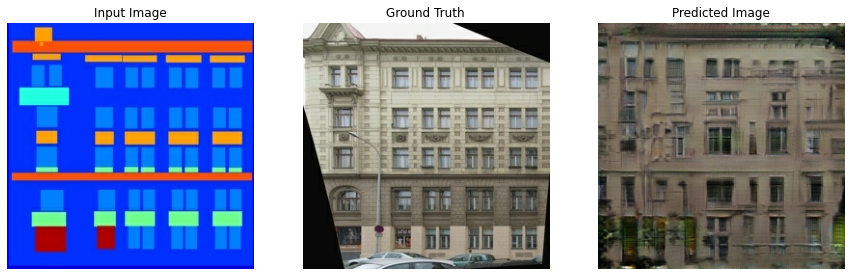

Epoch: 149
.Total Generator Loss :  tf.Tensor(39.276737, shape=(), dtype=float32)
Total Discriminator Loss :  tf.Tensor(0.1685041, shape=(), dtype=float32)
Generator Loss :  tf.Tensor(3.8876386, shape=(), dtype=float32)
.Total Generator Loss :  tf.Tensor(34.750248, shape=(), dtype=float32)
Total Discriminator Loss :  tf.Tensor(1.1353577, shape=(), dtype=float32)
Generator Loss :  tf.Tensor(1.7492307, shape=(), dtype=float32)
.Total Generator Loss :  tf.Tensor(35.39016, shape=(), dtype=float32)
Total Discriminator Loss :  tf.Tensor(0.1858581, shape=(), dtype=float32)
Generator Loss :  tf.Tensor(2.959777, shape=(), dtype=float32)
.Total Generator Loss :  tf.Tensor(36.300083, shape=(), dtype=float32)
Total Discriminator Loss :  tf.Tensor(0.2646756, shape=(), dtype=float32)
Generator Loss :  tf.Tensor(2.1406953, shape=(), dtype=float32)
.Total Generator Loss :  tf.Tensor(39.055195, shape=(), dtype=float32)
Total Discriminator Loss :  tf.Tensor(0.93642926, shape=(), dtype=float32)
Generator

In [38]:
with tf.device('/gpu:0'):
  Fit(train,epochs,test)